<a href="https://colab.research.google.com/github/hellocybernetics/TensorFlow_Eager_Execution_Tutorials/blob/master/tutorials/99_others/hyper_parameter_optimization_using_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

In [0]:
import numpy as np
import tensorflow as tf
import optuna
import matplotlib.pyplot as plt
%matplotlib inline

## Simple Practice
### objective function

$$
f(x) = 2x^4 - 5x^2 + x
$$

We will find the minimum value of $f(x^*)$ and $x^*$ using optuna which is provided Prefferd Networks.

### graph of $f(x)$

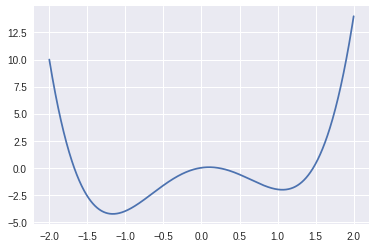

In [3]:
x = np.linspace(-2, 2, 1000)
plt.plot(x, 2*x**4 - 5*x**2 + x)

### optimization
We will minimize $f(x)$ where $x \in [-2, 2]$.

In [0]:
def objective(trial):
    x = trial.suggest_uniform('x', -2, 2)
    return 2*x**4 - 5*x**2 + x

In [5]:
study = optuna.create_study()
study.optimize(objective, n_trials=30)

[I 2018-12-03 10:31:56,787] Finished a trial resulted in value: -0.5300725948096164. Current best value is -0.5300725948096164 with parameters: {'x': 0.4676137258323778}.
[I 2018-12-03 10:31:56,794] Finished a trial resulted in value: -0.35272751992672957. Current best value is -0.5300725948096164 with parameters: {'x': 0.4676137258323778}.
[I 2018-12-03 10:31:56,804] Finished a trial resulted in value: -1.7286986521671333. Current best value is -1.7286986521671333 with parameters: {'x': -0.5205774008418671}.
[I 2018-12-03 10:31:56,812] Finished a trial resulted in value: -1.354773555213122. Current best value is -1.7286986521671333 with parameters: {'x': -0.5205774008418671}.
[I 2018-12-03 10:31:56,823] Finished a trial resulted in value: -0.29083295569339396. Current best value is -1.7286986521671333 with parameters: {'x': -0.5205774008418671}.
[I 2018-12-03 10:31:56,833] Finished a trial resulted in value: -3.9286181221456906. Current best value is -3.9286181221456906 with parameter

### result

minimum f(x) :  -4.021255980503703
argmin f(x) :  {'x': -1.0072075405886374}


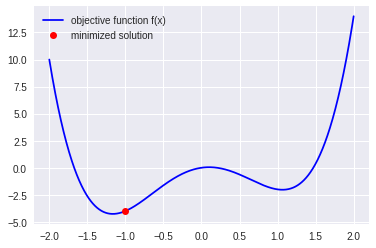

In [6]:
print("minimum f(x) : ", study.best_value)
print("argmin f(x) : ", study.best_params)

plt.plot(x, 2*x**4 - 5*x**2 + x, "b")
plt.plot(study.best_params['x'], study.best_value, "ro")
plt.legend(["objective function f(x)", "minimized solution"])

## optuna for TensorFlow Eager

In [0]:
tf.enable_eager_execution()

### Create model
In this section, create_model funtion have an arg `trial` which is represente search spaces of 'num of layers' and 'dropout_rate'.  

In [0]:
def create_model(trial):
    # num of hidden layer
    n_layers = trial.suggest_int('n_layers', 1, 3)
    
    # dropout_rate
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    
    layers = []
    for i in range(n_layers):
        layers.append(
            tf.keras.layers.Conv2D(filters=(i+1)*16, 
                                   kernel_size=3, 
                                   padding="same",
                                   activation="relu")
        )
        layers.append(
            tf.keras.layers.MaxPool2D(pool_size=2, padding="same")
        )
        layers.append(
            tf.keras.layers.Dropout(rate=dropout_rate)
        )
    
    layers.append(tf.keras.layers.Flatten())
    layers.append(tf.keras.layers.Dense(128, activation="relu"))
    layers.append(tf.keras.layers.Dense(10, activation="softmax"))
    
    return tf.keras.Sequential(layers)
    

### create optimizer
Then, we create optimzier.

In [0]:
def create_optimizer(trial):
    # Loguniform parameter
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    return optimizer

### create trainer
In this section we will create trainer which is simply training loop. We will use keras training API. 

In [0]:
def trainer(trial, x_train, y_train):
    
    batch_size=trial.suggest_categorical('batch_size', [256, 512, 1024])
    
    model = create_model(trial)
    optimizer = create_optimizer(trial)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=["accuracy"])

    model.fit(x=x_train,
              y=y_train,
              batch_size=batch_size,
              epochs=5,
              )

    return model

#### objective
We create objective function. Note that optuna minimize objective function, so when we create objective function, this is defined "better equal to smaller". Therefore, we define objective function "`1 - accuracy`".

In [0]:
def objective(trial):
    
    (x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)

    x_train_ = tf.convert_to_tensor(x_train, dtype=tf.float32)
    y_train_ = tf.reshape(tf.one_hot(y_train, 10), (-1, 10))
    x_test_ = tf.convert_to_tensor(x_test, dtype=tf.float32)
    y_test_ = tf.reshape(tf.one_hot(y_test, 10), (-1, 10))


    model = trainer(trial, x_train_, y_train_)
    
    evaluate = model.evaluate(x=x_test_, y=y_test_)
    return 1 - evaluate[1]

In [27]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

Epoch 1/5
235/235 [==============================] - 10s 41ms/step - loss: 1.4610 - acc: 0.6373
Epoch 2/5
235/235 [==============================] - 9s 40ms/step - loss: 0.4963 - acc: 0.8657
Epoch 3/5
235/235 [==============================] - 9s 40ms/step - loss: 0.3442 - acc: 0.9003
Epoch 4/5
235/235 [==============================] - 9s 40ms/step - loss: 0.2817 - acc: 0.9174
Epoch 5/5
313/313 [==============================] - 3s 10ms/step


[I 2018-12-03 11:16:46,145] Finished a trial resulted in value: 0.05559999999999998. Current best value is 0.05559999999999998 with parameters: {'batch_size': 256, 'n_layers': 2, 'dropout_rate': 0.08911466576943422, 'learning_rate': 6.35606519224162e-05}.


Epoch 1/5
118/118 [==============================] - 7s 60ms/step - loss: 0.7680 - acc: 0.7434
Epoch 2/5
118/118 [==============================] - 8s 66ms/step - loss: 0.2282 - acc: 0.9275
Epoch 3/5
118/118 [==============================] - 8s 66ms/step - loss: 0.1687 - acc: 0.9463
Epoch 4/5
118/118 [==============================] - 8s 66ms/step - loss: 0.1351 - acc: 0.9577
Epoch 5/5
313/313 [==============================] - 4s 11ms/step


[I 2018-12-03 11:17:29,919] Finished a trial resulted in value: 0.01419999999999999. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


Epoch 1/5
59/59 [==============================] - 3s 53ms/step - loss: 2.1476 - acc: 0.4152
Epoch 2/5
59/59 [==============================] - 3s 51ms/step - loss: 1.7132 - acc: 0.7424
Epoch 3/5
59/59 [==============================] - 3s 50ms/step - loss: 1.3003 - acc: 0.8039
Epoch 4/5
59/59 [==============================] - 3s 50ms/step - loss: 0.9942 - acc: 0.8303
Epoch 5/5
313/313 [==============================] - 3s 8ms/step


[I 2018-12-03 11:17:48,940] Finished a trial resulted in value: 0.12760000000000005. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


Epoch 1/5
59/59 [==============================] - 3s 48ms/step - loss: 2.1955 - acc: 0.2540
Epoch 2/5
59/59 [==============================] - 3s 49ms/step - loss: 1.9026 - acc: 0.6144
Epoch 3/5
59/59 [==============================] - 3s 49ms/step - loss: 1.5499 - acc: 0.7589
Epoch 4/5
59/59 [==============================] - 3s 48ms/step - loss: 1.2352 - acc: 0.8062
Epoch 5/5
313/313 [==============================] - 2s 8ms/step


[I 2018-12-03 11:18:07,097] Finished a trial resulted in value: 0.1431. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


Epoch 1/5
118/118 [==============================] - 5s 47ms/step - loss: 2.2628 - acc: 0.1551
Epoch 2/5
118/118 [==============================] - 5s 45ms/step - loss: 2.1608 - acc: 0.3714
Epoch 3/5
118/118 [==============================] - 5s 45ms/step - loss: 2.0188 - acc: 0.5907
Epoch 4/5
118/118 [==============================] - 5s 45ms/step - loss: 1.8300 - acc: 0.6913
Epoch 5/5
313/313 [==============================] - 3s 10ms/step


[I 2018-12-03 11:18:38,545] Finished a trial resulted in value: 0.23160000000000003. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


Epoch 1/5
59/59 [==============================] - 4s 69ms/step - loss: 1.2967 - acc: 0.6230
Epoch 2/5
59/59 [==============================] - 4s 67ms/step - loss: 0.4508 - acc: 0.8591
Epoch 3/5
59/59 [==============================] - 4s 67ms/step - loss: 0.3262 - acc: 0.9006
Epoch 4/5
59/59 [==============================] - 4s 67ms/step - loss: 0.2617 - acc: 0.9203
Epoch 5/5
313/313 [==============================] - 3s 10ms/step


[I 2018-12-03 11:19:03,104] Finished a trial resulted in value: 0.038900000000000046. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


Epoch 1/5
118/118 [==============================] - 5s 45ms/step - loss: 1.7213 - acc: 0.6222
Epoch 2/5
118/118 [==============================] - 5s 45ms/step - loss: 0.5709 - acc: 0.8596
Epoch 3/5
118/118 [==============================] - 5s 44ms/step - loss: 0.3442 - acc: 0.9040
Epoch 4/5
118/118 [==============================] - 6s 48ms/step - loss: 0.2693 - acc: 0.9237
Epoch 5/5
313/313 [==============================] - 3s 10ms/step


[I 2018-12-03 11:19:35,882] Finished a trial resulted in value: 0.05449999999999999. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


Epoch 1/5
118/118 [==============================] - 4s 36ms/step - loss: 2.2224 - acc: 0.2468
Epoch 2/5
118/118 [==============================] - 4s 36ms/step - loss: 1.9894 - acc: 0.5247
Epoch 3/5
118/118 [==============================] - 4s 36ms/step - loss: 1.6933 - acc: 0.6963
Epoch 4/5
118/118 [==============================] - 4s 35ms/step - loss: 1.4206 - acc: 0.7748
Epoch 5/5
313/313 [==============================] - 2s 8ms/step


[I 2018-12-03 11:20:00,746] Finished a trial resulted in value: 0.16869999999999996. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


Epoch 1/5
59/59 [==============================] - 4s 68ms/step - loss: 2.0938 - acc: 0.3510
Epoch 2/5
59/59 [==============================] - 4s 67ms/step - loss: 1.3368 - acc: 0.6775
Epoch 3/5
59/59 [==============================] - 4s 67ms/step - loss: 0.7983 - acc: 0.7744
Epoch 4/5
59/59 [==============================] - 4s 67ms/step - loss: 0.6150 - acc: 0.8143
Epoch 5/5
313/313 [==============================] - 3s 10ms/step


[I 2018-12-03 11:20:25,199] Finished a trial resulted in value: 0.11060000000000003. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


Epoch 1/5
235/235 [==============================] - 7s 30ms/step - loss: 0.2308 - acc: 0.9313
Epoch 2/5
235/235 [==============================] - 7s 30ms/step - loss: 0.0722 - acc: 0.9784
Epoch 3/5
235/235 [==============================] - 7s 29ms/step - loss: 0.0481 - acc: 0.9850
Epoch 4/5
235/235 [==============================] - 7s 29ms/step - loss: 0.0384 - acc: 0.9877
Epoch 5/5
313/313 [==============================] - 3s 10ms/step


[I 2018-12-03 11:21:04,984] Finished a trial resulted in value: 0.015499999999999958. Current best value is 0.01419999999999999 with parameters: {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}.


In [29]:
study.trials

[FrozenTrial(trial_id=0, state=<TrialState.COMPLETE: 1>, value=0.05559999999999998, datetime_start=datetime.datetime(2018, 12, 3, 11, 15, 53, 871134), datetime_complete=datetime.datetime(2018, 12, 3, 11, 16, 46, 145459), params={'batch_size': 256, 'n_layers': 2, 'dropout_rate': 0.08911466576943422, 'learning_rate': 6.35606519224162e-05}, user_attrs={}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'batch_size': 0, 'n_layers': 2, 'dropout_rate': 0.08911466576943422, 'learning_rate': 6.35606519224162e-05}),
 FrozenTrial(trial_id=1, state=<TrialState.COMPLETE: 1>, value=0.01419999999999999, datetime_start=datetime.datetime(2018, 12, 3, 11, 16, 46, 152379), datetime_complete=datetime.datetime(2018, 12, 3, 11, 17, 29, 918984), params={'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}, user_attrs={}, system_attrs={}, intermediate_values={}, params_in_internal_repr={'batch_size': 1, 'n_layers': 3, 'dropout_rate':

In [33]:
print("best params: ", study.best_params)
print("best test accuracy: ", 1 - study.best_value)

best params:  {'batch_size': 512, 'n_layers': 3, 'dropout_rate': 0.37064663092391686, 'learning_rate': 0.0015806562771231835}
best test accuracy:  0.9858
